<a href="https://colab.research.google.com/github/pramodith/llm_exploration/blob/main/FormattedTextSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Embedding Models and Formatted Unicode Text

Many platforms and documents like LinkedIn support specially formatted textual characters, such as bold, italicized etc. text.

The unicode representation of such characters is different from the standard unformatted i.e. ascii representation. This can pose problems to LMs depending on how the tokenizer handles such characters. Here's an online [tool](https://www.linkedin-makeover.com/linkedin-text-formatter/) one can use to format their text on LI.

In this notebook we explore how Embedding Models can be affected. This notebook is inspired by [Prithivi Da](https://github.com/PrithivirajDamodaran)'s LinkedIn [post](https://www.linkedin.com/posts/prithivirajdamodaran_curious-case-of-vector-search-fails-most-activity-7128981613438218240-esX_/?utm_source=share&utm_medium=member_ios) highlighting the same issue.

Let's install all the libraries we'll be using!

In [30]:
!pip install -qqq datasets
!pip install -qqq accelerate
!pip install -qqq einops
!pip install -qqq openai
!pip install -qqq cohere --upgrade


Import all the packages we need.

In [3]:
from transformers import AutoTokenizer, AutoModel
from typing import List
from openai import OpenAI
import cohere
from datasets import load_dataset
from google.colab import userdata
import torch
import torch.nn.functional as F
import time
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

We'll test out the following embedding models.

In [4]:
E5_EMBEDDING_MODEL = "intfloat/e5-base-v2"
MXBD_EMBEDDING_MODEL = "mixedbread-ai/mxbai-embed-large-v1"
GTE_LARGE_EN = "Alibaba-NLP/gte-large-en-v1.5"
JINA_AI = "jinaai/jina-embeddings-v2-base-en"
OPEN_AI = "open-ai"
COHERE = "cohere"

Let's create a reference positive pair of documents i.e. somewhat related and a negative pair of documents.

The cosine similarity scores of the positive pair and negative pair will be used to assess how well the embedding models listed above handle formatted text. Ideally the cosine similarity between unformatted and formatted documents should be 1 if they contain the same content.

However some tokenizers might map formatted and unformatted unicode characters to different token ids, which may be undertrained or worse all formatted tokens might be mapped to an [UNK] token which is the case for a lot of the open source models built on top of **BERT**.

This ultimately leads to non 1 cosine similarity scores. The reference positive and negative scores will therefore help us calibrate how well our embedding model deals with formatted text. Ideally we should still be closer to the score of the positive pair of docs.

In [5]:
ANCHOR_DOC = "Will Taylor Swift make it to the Superbowl?"
NEGATIVE_DOC = "A zebra grazes in the wild"
POSITIVE_DOC = "The ads to lookout for at the Superbowl."
MODELS = [E5_EMBEDDING_MODEL, JINA_AI, OPEN_AI, COHERE]

A function to create bolded text.

In [6]:
def to_bold(text):
    """
    This function was generated using GPT
    """
    def bold_char(c):
        if 'a' <= c <= 'z':
            return chr(ord(c) + 0x1D41A - ord('a'))
        elif 'A' <= c <= 'Z':
            return chr(ord(c) + 0x1D400 - ord('A'))
        elif '0' <= c <= '9':
            return chr(ord(c) + 0x1D7CE - ord('0'))
        else:
            return c

    return ''.join(bold_char(c) for c in text)

# Example usage
original_text = "Hello World"
bolded_text = to_bold(original_text)
print(bolded_text)


𝐇𝐞𝐥𝐥𝐨 𝐖𝐨𝐫𝐥𝐝


In [7]:
sample_text = "Hello World"
bolded_text = to_bold(sample_text)

Get a sample of formatted text for comparison using this free [tool](https://www.linkedin-makeover.com/linkedin-text-formatter/).

In [8]:
bolded_text == "𝐇𝐞𝐥𝐥𝐨 𝐖𝐨𝐫𝐥𝐝"

True

Let's load a 1000 sample documents from a dataset and create a dataset of bolded and plain documents.

In [9]:

ds = load_dataset("sentence-transformers/all-nli", "pair", split="train[:1500]")
docs = list(set(ds["anchor"]))[:1000]
bolded_docs = [to_bold(doc) for doc in docs]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/314315 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/6808 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6831 [00:00<?, ? examples/s]

In [10]:
docs[0]

'There is a woman holding a baby, along with a man with a save the children bag.'

In [11]:
bolded_docs[0]

'𝐓𝐡𝐞𝐫𝐞 𝐢𝐬 𝐚 𝐰𝐨𝐦𝐚𝐧 𝐡𝐨𝐥𝐝𝐢𝐧𝐠 𝐚 𝐛𝐚𝐛𝐲, 𝐚𝐥𝐨𝐧𝐠 𝐰𝐢𝐭𝐡 𝐚 𝐦𝐚𝐧 𝐰𝐢𝐭𝐡 𝐚 𝐬𝐚𝐯𝐞 𝐭𝐡𝐞 𝐜𝐡𝐢𝐥𝐝𝐫𝐞𝐧 𝐛𝐚𝐠.'

Add in your API keys to test the embedding models provided by OPEN AI and Cohere.

In [12]:
open_ai_key = userdata.get('OPENAI_API_KEY')
cohere_key = userdata.get('COHERE_API_KEY')

Let's create functions to get the embedding models and their tokenizers if they are on HF or the corresponding API clients for private vendors.

In [13]:
def get_model_and_tokenizer(model_name: str):
  """
  Returns the model and tokenizer for the given model name.
  """
  if model_name == "open-ai":
    client = OpenAI(api_key=open_ai_key)
    return client, None
  elif model_name == "cohere":
    client = cohere.Client(cohere_key)
    return client, None
  else:
    embedding_model = AutoModel.from_pretrained(model_name, device_map="cuda", trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return embedding_model, tokenizer

Some open source embedding models prefer CLS pooling while others prefer mean pooling to obtain the final embedding representation of a document.

In [14]:
def cls_pooling(outputs: torch.Tensor):
  """
  Returns the cls pooling of the last hidden states.
  """
  outputs = outputs[:, 0]
  return outputs

def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    """
    Returns the average pooling of the last hidden states.
    """
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

@torch.inference_mode
def get_embeddings(input_texts: List[str], strategy: str ="avg", model_name: str = E5_EMBEDDING_MODEL) -> Tensor:
  """
  Returns the embeddings for the given input texts.
  :param input_texts: List of input texts.
  :param strategy: Strategy to use for pooling the embeddings.
  :param model_name: Name of the embedding model.
  :return: Tensor of embeddings.
  """
  embedding_model, tokenizer = get_model_and_tokenizer(model_name)
  if model_name == OPEN_AI:
    api_response = embedding_model.embeddings.create(input = input_texts, model="text-embedding-3-small").data
    embeddings = []
    for emb in api_response:
      embeddings.append(emb.embedding)
    return torch.tensor(embeddings)
  if model_name == COHERE:
    embeddings = []
    for batch_ind in tqdm(range(0, len(input_texts), 96)):
      batch = input_texts[batch_ind:batch_ind+96]
      api_response = embedding_model.embed(texts=batch, model="embed-english-v3.0", input_type="clustering")
      embeddings.extend(api_response.embeddings)
      # Trial key only supports 5 requests per minute
      time.sleep(12)
    return torch.tensor(embeddings)
  else:
    # Tokenize the input texts
    batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt').to("cuda")
    if model_name == JINA_AI:
      embeddings = torch.tensor(embedding_model.encode(input_texts))
    else:
      outputs = embedding_model(**batch_dict)
      if strategy == "cls":
        embeddings = cls_pooling(outputs.last_hidden_state)
      else:
        embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

    embeddings = F.normalize(embeddings, p=2, dim=1)
    # normalize embeddings
    return embeddings.detach().cpu()

## Results

Let's now compute boxplots for the cosine similarities of each embedding model. Notice how for all models our median is always below the reference positive cosine similarity score indicating that none of these models properly account for formatted unicode.

In some cases we see that the similarity scores between the formatted and unformatted text is lower than our negative anchor score. Highlighting the failure of these models to deal with formatted text.

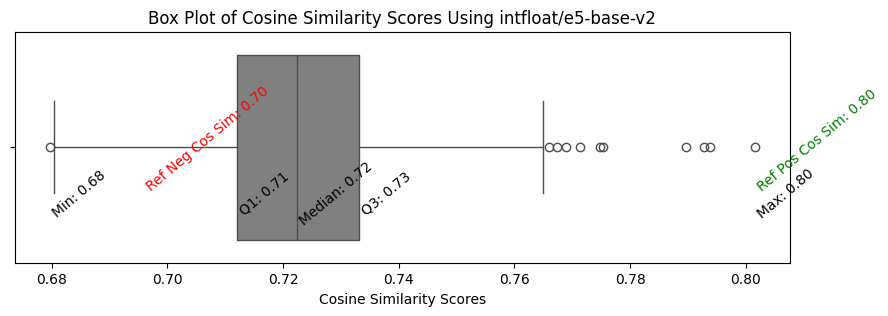

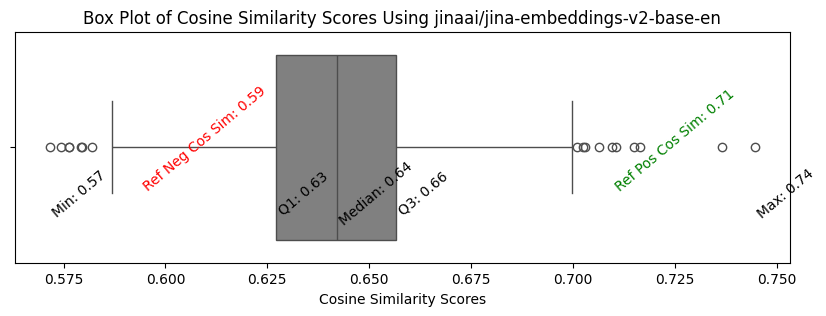

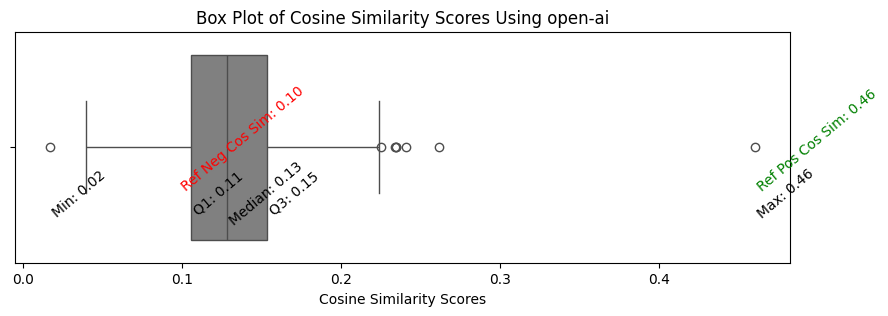

100%|██████████| 1/1 [00:12<00:00, 12.15s/it]


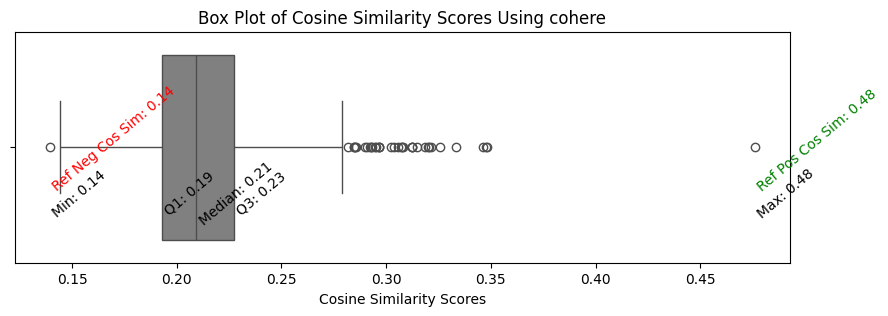

In [29]:
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

for model_name in MODELS:
  embs = get_embeddings(docs, model_name=model_name)
  bolded_embs = get_embeddings(bolded_docs, model_name=model_name)
  calibration_positive_embedding = get_embeddings([ANCHOR_DOC, POSITIVE_DOC], model_name=model_name)
  reference_positive_cos_sim = cos(calibration_positive_embedding[:1], calibration_positive_embedding[1:])
  calibration_negative_embedding = get_embeddings([ANCHOR_DOC, NEGATIVE_DOC], model_name=model_name)
  reference_negative_cos_sim = cos(calibration_negative_embedding[:1], calibration_negative_embedding[1:])
  # Sample cosine similarity scores
  cosine_sim_scores = torch.concat([cos(embs, bolded_embs), reference_negative_cos_sim, reference_positive_cos_sim])
  reference_negative_cos_sim = reference_negative_cos_sim.numpy()[0]
  reference_positive_cos_sim = reference_positive_cos_sim.numpy()[0]
  # Create a DataFrame
  data = pd.DataFrame({
      "Cosine Similarity Scores": cosine_sim_scores.numpy()
  })

  # Create a box plot
  plt.figure(figsize=(10, 3))
  sns.boxplot(x="Cosine Similarity Scores", data=data, orient='h', color='gray', saturation=0.5)
  plt.title(f"Box Plot of Cosine Similarity Scores Using {model_name}")

  # Calculate summary statistics
  min_val = data["Cosine Similarity Scores"].min()
  q1 = data["Cosine Similarity Scores"].quantile(0.25)
  median = data["Cosine Similarity Scores"].median()
  q3 = data["Cosine Similarity Scores"].quantile(0.75)
  max_val = data["Cosine Similarity Scores"].max()

  # Annotate the plot
  plt.text(min_val, 0.20, f'Min: {min_val:.2f}', horizontalalignment='left', verticalalignment='center', rotation=40)
  plt.text(q1, 0.20, f'Q1: {q1:.2f}', horizontalalignment='left', verticalalignment='center', rotation=40)
  plt.text(median, 0.20, f'Median: {median:.2f}', horizontalalignment='left', verticalalignment='center', rotation=40)
  plt.text(q3, 0.20, f'Q3: {q3:.2f}', horizontalalignment='left', verticalalignment='center', rotation=40)
  plt.text(max_val, 0.20, f'Max: {max_val:.2f}', horizontalalignment='left', verticalalignment='center', rotation=40)
  plt.text(reference_positive_cos_sim, 0.20, f'Ref Pos Cos Sim: {reference_positive_cos_sim:.2f}', horizontalalignment='left', verticalalignment='bottom', rotation=40, color='green')
  plt.text(reference_negative_cos_sim, 0.20, f'Ref Neg Cos Sim: {reference_negative_cos_sim:.2f}', horizontalalignment='left', verticalalignment='bottom', rotation=40, color='red')
  # Show the plot
  plt.show()


## Solution

A library called [unidecode](https://pypi.org/project/Unidecode/) to pre-process your text.

In [16]:
!pip install unidecode


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.1 MB/s eta 0:00:00


In [19]:
from unidecode import unidecode
print(unidecode(bolded_text))

Hello World
